# 0. Intro / ReadMe

This notebook aims to summarize all everything we've investigated. Most of the heavy computation and in-depth analysis is in other notebooks, but many results only exist here in the current version.

The dataframes `posts` and `users` are created by the `data.wiki` module from the raw corpus (if no corresponding `.pickle` file exists). Other notebooks add colums to those dataframes and some of those columns are necessary for this notebook to run. 

Here's what the other notebooks do:

- **WHAM subgroups** -- prepares data for running the WHAM model and compiles and runs the model (recommeneded to run this part in a script outside Jupyter, though)
- **Surprisal-based Alignment** -- analysis of the surprisal-based alignment metric that we ultimately abandoned 
- **Normalizing centrality** -- computes log-normalized centrality scores for the user network and adds `centrality` to the `user` dataframe.
- **(W)SCP Alignment** -- replication of the _Echoes of Power_ result; defines word-based SCP; investigates inverted effects for certain indicator categories for WSCP
- **Stylistic Typicality PPL** -- creates datasets for the LSTM language model and computes utterance perplexity for the all-item and year-specific conditions (`model.py` and `lm_train.py` contain the LSTM model and training code)
- **Stylistic Typicality PoS N-Grams** -- investigates Kullback Leibler divergence for PoS 3- and 4-gram distributions in high/low power user utterances

In [1]:
from data import wiki
from data import corpus
import util
import alignment

import nltk
import pandas as pd
import numpy as np
import pickle

import math
import scipy

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

markers = alignment.load_markers()
markers_list = list(markers)

posts = wiki.load_posts(recreate=False)
posts = corpus.tokenize_posts(posts, lower_case=True, overwrite=False)
posts = corpus.detect_markers(posts, markers, overwrite=False)

pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)

/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/corpus.py:18: UserWarning: Posts are already tokenized. Skipping tokenization.
  warnings.warn("Posts are already tokenized. Skipping tokenization.")
/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/corpus.py:64: UserWarning: All marker columns already exist. Skipping marker detection.
  warnings.warn("All marker columns already exist. Skipping marker detection.")


# 1. Descriptive statistics

In [2]:
print("{} users total".format(len(users)))
if not 'centrality' in users:
    print("Run Normalizing Centrality.ipynb first.")
threshold = users.centrality.mean() + users.centrality.std() # compute highly central threshold
users['highly_central'] = (users['centrality'] > threshold)
print("{} highly-central users (centrality > {:0.2f})".format(users.highly_central.sum(), threshold))
print("{} users with admin status".format(users.admin.sum()))
print("{} total posts".format(len(posts)))

30900 users total
1893 highly-central users (centrality > 0.83)
1812 users with admin status
376923 total posts


## 1.1 Centrality and adminship

User counts by normalized centrality (blue for admins).


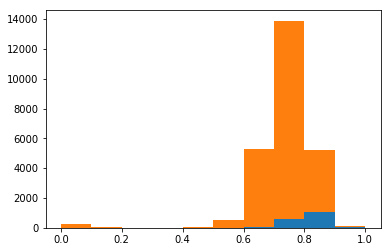

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
x1 = [user.centrality for i, user in users[users.admin].iterrows() if not np.isnan(user.centrality)]
x2 = [user.centrality for i, user in users[~users.admin].iterrows() if not np.isnan(user.centrality)]
plt.figure()
plt.hist([x1,x2], stacked=True)
print("User counts by normalized centrality (blue for admins).")

Centrality by post count (blue points are admins).


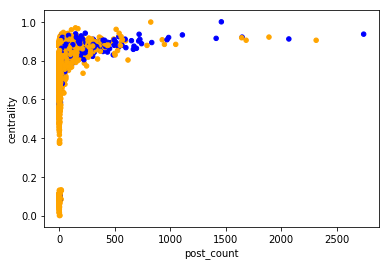

In [4]:
cs = ['blue' if user.admin else 'orange' for i,user in users.iterrows()]
users.plot.scatter('post_count', 'centrality', c=cs)
print("Centrality by post count (blue points are admins).")

## 1.2 Linguistic style markers

Per-user marker baselines.


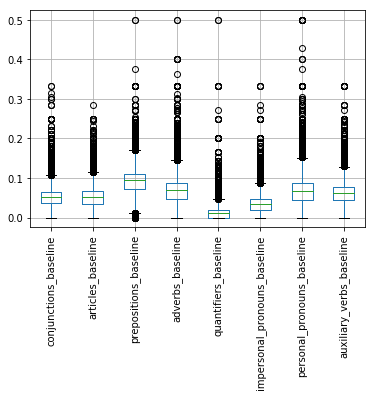

In [5]:
print("Per-user marker baselines.")
posts['len_tokens'] = posts['tokens'].apply(len)
pairs['len_tokens_b'] = pairs['tokens_b'].apply(len)

user_marker_totals = posts.groupby('user')[['len_tokens'] + list(markers)].sum()
for m in markers:
    users[m + '_baseline'] = user_marker_totals[m] / user_marker_totals['len_tokens']
    pairs = pairs.merge(users[[m+'_baseline']], left_on='user_b', right_index=True)

fig = users.boxplot(column=[m+'_baseline' for m in markers_list], rot=90)

# 2. SCP Coordination Results

## 2.1 Echoes of Power replication

We replicate the result that higher-power groups recieve more coordination than low-power groups (for both the adminship and highly-central conditions).

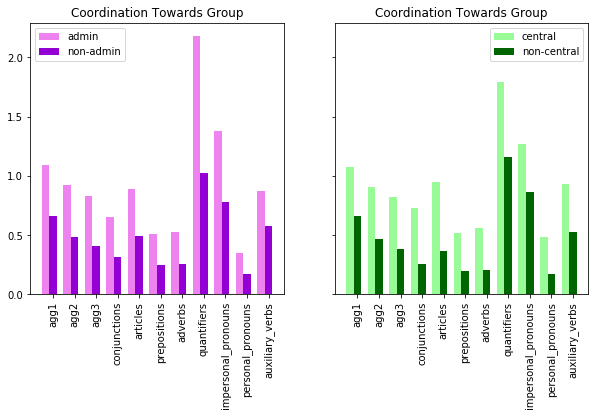

In [6]:
from alignment import scp, plot_scp

df = posts.merge(users, left_on='user', right_index=True)
df = df.merge(df, left_index=True, right_on='reply_to', suffixes=('_a', '_b'))

admin_scp = alignment.scp(df, 'admin')
central_scp = alignment.scp(df, 'highly_central')

data = (admin_scp, central_scp)
labels = (['admin', 'non-admin'], ['central', 'non-central'])
colors = (['violet', 'darkviolet'], ['palegreen', 'darkgreen'])
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
for ax, d, l, c in zip(axs, data, labels, colors):
    plot_scp(d, l, ax, c)
        

## 2.2 Coordination in sub-communities

Here we use Louvain Modularity to extract communities from the wiki network.

In [7]:
import igraph as ig
import louvain

network = wiki.load_network()
partition = louvain.find_partition(network, louvain.ModularityVertexPartition)

user_community = {}
for user in network.vs:
    user_community[user['name']] = partition.membership[user.index]
users['community'] = pd.Series(user_community)

com_sizes = users.community.value_counts()
coms = range(len(com_sizes))
com_sizes = [com_sizes.loc[com] for com in coms]
com_limit=32 # afetr 32 the communities get very small. Many are just disconnected components.

For visualization purposes, this _sub-community network_ considers the Louvain sub-communities as nodes. The edeges between them are weighted by the number of utterances between their members. The node size represents the numeber of users assigned to the sub-community.

In [8]:
import networkx as nx
com_network = nx.Graph()

for e in network.es:
    v1, v2 = partition.membership[e.source], partition.membership[e.target]
    for v in (v1,v2):
        if v in com_network:
            com_network.node[v]['weight'] += 1
        else:
            com_network.add_node(v, weight=1)
    if com_network.has_edge(v1,v2):
        com_network[v1][v2]['weight'] += e['weight']
    else:
        com_network.add_edge(v1, v2, weight=e['weight'])
        
com_network.remove_nodes_from(coms[com_limit:])

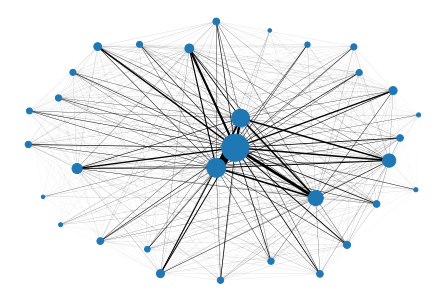

In [9]:
pos = nx.spring_layout(com_network, k=20)
edges = com_network.edges()
edge_weights = [com_network[u][v]['weight']/1000 for u,v in edges]
nodes = com_network.nodes()
node_weights = [com_network.nodes[v]['weight']/50 for v in nodes]

nx.draw(com_network, pos=pos, nodes=nodes, edges=edges, node_size=node_weights, width=edge_weights)

In [10]:
df = posts.merge(users, left_on='user', right_index=True)
df = df.merge(df, left_index=True, right_on='reply_to', suffixes=('_a', '_b'))
df['ingroup_a'] = df['community_a'] == df['community_b']
ingroup_scp = alignment.scp(df, 'ingroup') # compute alignment where A is in/out of B's sub-community

We find that users align more with those outside their Louvain community than those within it.

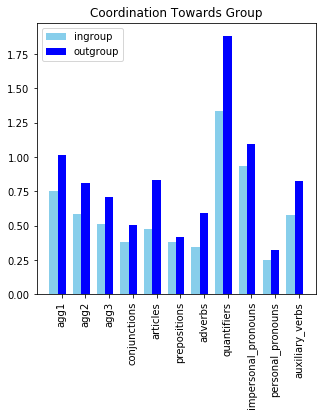

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(5,5))
plot_scp(ingroup_scp, ['ingroup', 'outgroup'], ax, colors=['skyblue', 'blue'])

Could this be a confound with power of some kind? Maybe it's just that when users talk to people outside their sub-community, they tend to be people with higher social power.

In [12]:
df.groupby('ingroup_a')[['admin_a', 'centrality_a']].mean()

,admin_a,centrality_a
ingroup_a,,
False,0.359392,0.841849
True,0.251477,0.814865


Indeed this does appear to be the case. When `A` is an outgroup user (outside `B`'s sub-community), they are more often an admin and tend to have slightly higher centrality.

So let's look at the same question of ingroup/outgroup coordination, but partitioned by high centrality/low centrality and admin/non-admin.

In [13]:
ingroup_scp_admins     = alignment.scp(df[df.admin_a==True], 'ingroup')
ingroup_scp_nonadmins  = alignment.scp(df[df.admin_a==False], 'ingroup')
ingroup_scp_central    = alignment.scp(df[df.highly_central_a==True], 'ingroup')
ingroup_scp_noncentral = alignment.scp(df[df.highly_central_a==False], 'ingroup')

The results are less pronounced for non-central/non-admin targets, but it's still the case that users coordinate more with those outside their sub-community.

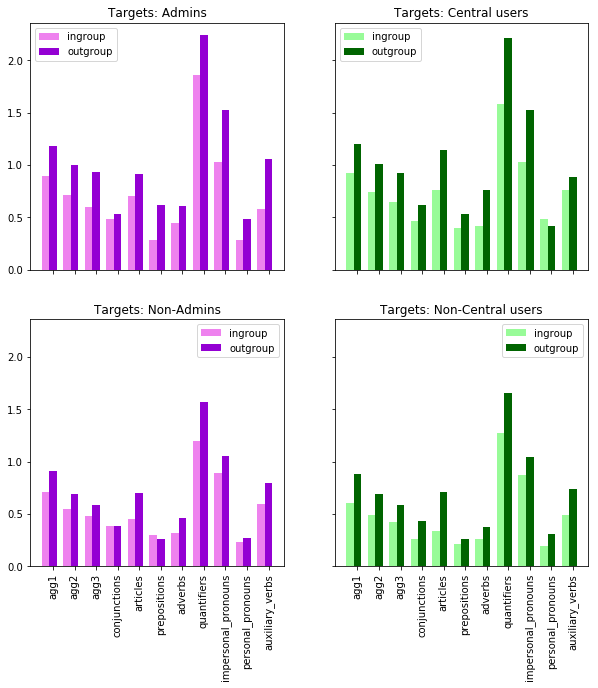

In [14]:
colors = (['violet', 'darkviolet'], ['palegreen', 'darkgreen'])
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
plot_scp(ingroup_scp_admins,    ['ingroup', 'outgroup'], axs[0][0], colors[0], title="Targets: Admins")
plot_scp(ingroup_scp_nonadmins, ['ingroup', 'outgroup'], axs[1][0], colors[0], title="Targets: Non-Admins")
plot_scp(ingroup_scp_central,   ['ingroup', 'outgroup'], axs[0][1], colors[1], title="Targets: Central users")
plot_scp(ingroup_scp_noncentral,['ingroup', 'outgroup'], axs[1][1], colors[1], title="Targets: Non-Central users")

To investigate further, we look at ingroup/outgroup targets (`A`) where `B` is part of a specific community.

In [15]:
centrality_means = [users[users.community==com].centrality.mean() for com in coms]
admin_percents = [100 * users[users.community==com].admin.mean() for com in coms]
scp_data, ingroup_agg1s, outgroup_agg1s = [], [], []
for com in coms:
    try: # alignment.scp is fails for the really small communities because of 0 division problems i haven't bothered to handle gracefully
        scp_data.append(alignment.scp(df[df.community_b == com], 'ingroup'))
        ingroup_agg1s.append(scp_data[com].loc[True].agg1.mean())
        outgroup_agg1s.append(scp_data[com].loc[False].agg1.mean())
    except:
        scp_data.append(None)
        ingroup_agg1s.append(np.nan)
        outgroup_agg1s.append(np.nan)

We define ingroup coordination bias for a given sub-community as the difference between aggregrated ingroup and outgroup coordination.

There appears to be a slight negative correlation between mean sub-community centrality and ingroup cordination bias (bottom plot). This helps confirm the above finding -- if negative ingroup coordination bias were merely the result of coordination with high-power outgroup members, we would expect high-power sub-communities to have higher ingroup coordination bias.

Comm | Size  | Avg. Centrality | % Admin   |Ingroup Agg1   | Outgroup Agg1
  0  |  3981 | 0.757           | 07.64     |  0.0104       |  0.0162
  1  |  2812 | 0.746           | 11.52     |  0.0037       |  0.0168
  2  |  2238 | 0.758           | 07.06     |  0.0090       |  0.0128
  3  |  2080 | 0.777           | 07.88     |  0.0073       |  0.0180
  4  |  1817 | 0.731           | 12.82     |  0.0092       |  0.0087
  5  |  1011 | 0.730           | 06.63     |  0.0123       |  0.0102
  6  |   735 | 0.778           | 05.58     | -0.0007       |  0.0095
  7  |   650 | 0.750           | 04.92     |  0.0152       |  0.0153
  8  |   628 | 0.743           | 05.25     |  0.0052       |  0.0149
  9  |   583 | 0.756           | 04.12     |  0.0027       |  0.0180
 10  |   525 | 0.733           | 03.62     |  0.0046       |  0.0117
 11  |   479 | 0.748           | 02.51     |  0.0056       |  0.0172
 12  |   475 | 0.722           | 05.89     |  0.0073       |  0.0146
 13  |   474 | 0.717        

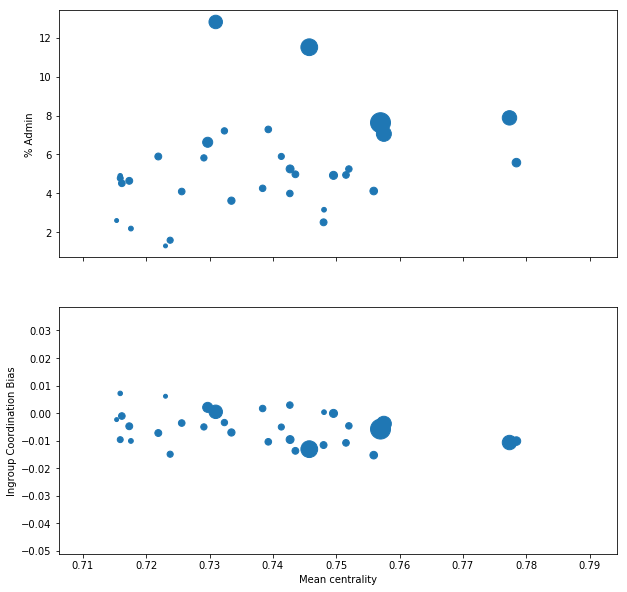

In [16]:
print("Comm | Size  | Avg. Centrality | % Admin   |Ingroup Agg1   | Outgroup Agg1")
for com in coms[:com_limit]: 
    print("{:>3}  | {:>5} | {:.3f}           | {:05.2f}     | {: .4f}       | {: .4f}".format(com, com_sizes[com], centrality_means[com], admin_percents[com], ingroup_agg1s[com], outgroup_agg1s[com]))
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,10))
ax1.scatter(centrality_means[:com_limit], admin_percents[:com_limit], s=[x/10 for x in com_sizes])
ingroup_bias = [x-y for x,y in list(zip(ingroup_agg1s, outgroup_agg1s))[:com_limit]]
ax2.scatter(centrality_means[:com_limit], ingroup_bias, s=[x/10 for x in com_sizes])
plt.xlabel("Mean centrality")
ax1.set_ylabel("% Admin")
ax2.set_ylabel("Ingroup Coordination Bias")
plt.show()

# 3. Typicality via utterance perplexity

In [17]:
assert('ppl_year' in posts and 'ppl_all' in posts)
df = posts.merge(users, right_on='user', left_on='user')

We trained simple word-based LSTM language models. One for the whole corpus, and one for each individual year. To achieve a consistent fit, training was halted when each language model reached a consistend threshold validation perplexity.

Perplexity was evaluated for each utterance with the global language model (`ppl_all`) and the language model from the same year as the utterance (`ppl_year`).

## 3.1 Perplexity vs. power

First we consider the relationship between utterance perplexity and social power.

Both Adminship and high centrality have a negative association with utterance perplexity (socially powerful users speak less typcially of the community as a whole), but the effect size is small for adminship and negligable for centrality.

In [18]:
print("Utterance perplexity for central/non-central")
util.binary_comparison_stats(df.ppl_all, df.highly_central)
print("Utterance perplexity for admin/non-admins")
util.binary_comparison_stats(df.ppl_all, df.admin)

Utterance perplexity for central/non-central
|Condition |   True   |   False   |
|---------------------------------|
|        N |   177083 |   199397  |
|     mean |    29.06 |    29.17  |
|   stddev |    15.38 |    15.84  |
|---------------------------------|
t-statistic: -2.13 p-value:  0.033
Cohen's D: -0.01

Utterance perplexity for admin/non-admins
|Condition |   True   |   False   |
|---------------------------------|
|        N |   116082 |   260398  |
|     mean |    27.56 |    29.78  |
|   stddev |    14.78 |    15.92  |
|---------------------------------|
t-statistic: -39.22 p-value:  0.000
Cohen's D: -0.14



The correlation between raw centrality score and perplexity is also not significant.

In [19]:
r, p = scipy.stats.stats.pearsonr(*np.hsplit(df[['centrality', 'ppl_all']].dropna(), 2))
print("Pearson's correlation of user centrality vs utt perplexity: {:.4f} (p={:.3f})".format(r[0],p[0]))

Pearson's correlation of user centrality vs utt perplexity: -0.0047 (p=0.006)


## 3.2 Trendiness vs. power

We define the trendiness of an utterance as the difference between its perplexity under the global language model and the current-year language model. Trendiness >0 means the utterance is more typical of the current year than it is of the corpus as a whole.

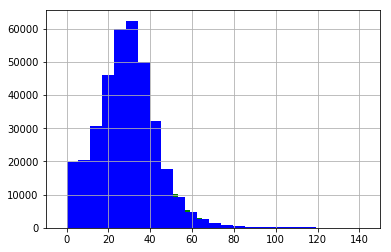

             mean (std)
PPL Year:   31.84 (15.31)
PPL ALL:    29.12 (15.62)
trendiness: -2.66 (9.31)


In [20]:
fig, ax = plt.subplots()
ax.set_xlim(-10, 150)

posts.ppl_year.hist(ax=ax, bins=100, color='Green')
posts.ppl_all.hist(ax=ax, bins=100, color='Blue')
plt.show()

print("             mean (std)")
print("PPL Year:   {:.2f} ({:0.2f})".format(df.ppl_year.mean(), df.ppl_year.std()))
print("PPL ALL:    {:.2f} ({:0.2f})".format(df.ppl_all.mean(), df.ppl_all.std()))
print("trendiness: {:.2f} ({:0.2f})".format((df.ppl_all - df.ppl_year).mean(), (df.ppl_all - df.ppl_year).std()))

Here we see that trendiness is lower for central users and higher for admins. Again, the effect sizes are very small.

In [21]:
df['trendiness'] = df.ppl_all - df.ppl_year
print("Trendiness for central/non-central")
util.binary_comparison_stats(df.trendiness, df.highly_central)
print("Trendiness for admin/non-admins")
util.binary_comparison_stats(df.trendiness, df.admin)

Trendiness for central/non-central
|Condition |   True   |   False   |
|---------------------------------|
|        N |   177083 |   199397  |
|     mean |    -2.76 |    -2.58  |
|   stddev |     9.15 |     9.46  |
|---------------------------------|
t-statistic: -5.78 p-value:  0.000
Cohen's D: -0.02

Trendiness for admin/non-admins
|Condition |   True   |   False   |
|---------------------------------|
|        N |   116082 |   260398  |
|     mean |    -2.35 |    -2.80  |
|   stddev |     8.71 |     9.56  |
|---------------------------------|
t-statistic:  13.43 p-value:  0.000
Cohen's D:  0.05



The correlaion between centrality centrality **is** significant.

Sanity check: since there is no correlation between centrality and PPL in the all-time language model, that must mean there is a relationship between centrality PPL in the current-year language model (indeed there is).

In [22]:
r, p = scipy.stats.stats.pearsonr(*np.hsplit(df[['centrality', 'trendiness']].dropna(), 2))
print("Pearson's correlation of user centrality vs trendiness: {:.4f} (p={:.3f})".format(r[0],p[0]))
r, p = scipy.stats.stats.pearsonr(*np.hsplit(df[['centrality', 'ppl_year']].dropna(), 2))
print("Pearson's correlation of user centrality vs current-year PPL: {:.4f} (p={:.3f})".format(r[0],p[0]))

Pearson's correlation of user centrality vs trendiness: -0.0069 (p=0.000)
Pearson's correlation of user centrality vs current-year PPL: -0.0019 (p=0.255)


# 4. Measures of style/typicality

## 4.1 PoS N-gram typicality

See `Stylistic Typicality PoS N-Grams.ipynb` for details.

Admin 3 and 4-grams distribution have higher Kullback-Leibler divergence from the overall user n-gram distributions than do central users

| KLD     | Admin  | Highly-Central |
|---------|--------|----------------|
| 3-grams | 0.0120 | 0.0056         |
| 4-grams | 0.0529 | 0.0268         |

The trigrams that contribute to their KLD are quite different between admins and highly-central users.

Top indicative 3-grams (admins)

|   n-gram    | top examples                                        | KLD contribution|
|-------------|-----------------------------------------------------|-----------------|
|`NNP NNP :`  | \[ WP : ; \[ User : ; [ Wikipedia :                 | 0.001072        |
|`NNP : NNP`  | Wikipedia : Criteria ; WP : CSD ; Wikipedia : Media | 0.000978        |
|`PRP MD VB ` | it would be ; i 'd like; i would like               | 0.000762        |

Top indicitive 3-grams (highly central)

|  n-gram     | top examples                               | KLD contribution|
|-------------|--------------------------------------------|-----------------|
|`PRP VBP RB` | i do n't ; i 'm not ; you do n't           | 0.000371        |
|`PRP MD VB`  | it would be ; i 'd like; i would like      | 0.000335        |
|`IN PRP VBP` | if you have ; that you have ; that you are | 0.000284        |


# 4.2 Formatting features

In [23]:
import re

posts['has_link']    = posts['clean_text'].apply(lambda x: re.search('\[\[.+\]\]', x) is not None)
posts['has_bold']    = posts['clean_text'].apply(lambda x: re.search(r"'''.+'''", x) is not None)
posts['has_italics'] = posts['clean_text'].apply(lambda x: re.search(r"[^']''.+''[^']", x) is not None)
posts['length'] = posts.tokens.apply(len)
posts['ttr'] = posts.tokens.apply(lambda x: len(set(x)) / len(x))

df = posts.merge(users, right_on='user', left_on='user')

* Unlike highly-central users, admins are more likely to post links.
* Only admins have a significant (negative) correlation with post length

In [24]:
for feature in ['has_link', 'has_bold', 'has_italics', 'length',  'ttr']:
    print("=========== {:^11} ===========".format(feature))
    print("------------- Admin --------------")
    util.binary_comparison_stats(df[feature], df.admin)
    print("---------- Highly-central --------")
    util.binary_comparison_stats(df[feature], df.highly_central)
    print()

===========  has_link   ===========
------------- Admin --------------
|Condition |   True   |   False   |
|---------------------------------|
|        N |   116082 |   260398  |
|     mean |     0.32 |     0.30  |
|   stddev |     0.47 |     0.46  |
|---------------------------------|
t-statistic:  8.59 p-value:  0.000
Cohen's D:  0.03

---------- Highly-central --------
|Condition |   True   |   False   |
|---------------------------------|
|        N |   177083 |   199397  |
|     mean |     0.29 |     0.33  |
|   stddev |     0.45 |     0.47  |
|---------------------------------|
t-statistic: -22.62 p-value:  0.000
Cohen's D: -0.07


===========  has_bold   ===========
------------- Admin --------------
|Condition |   True   |   False   |
|---------------------------------|
|        N |   116082 |   260398  |
|     mean |     0.03 |     0.03  |
|   stddev |     0.17 |     0.18  |
|---------------------------------|
t-statistic: -8.42 p-value:  0.000
Cohen's D: -0.03

---------- Hig